# Lab 3 — dimensionality reduction

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle


from operator import itemgetter
from pyspark.sql import functions as F

%matplotlib inline
plt.style.use("ggplot")

In [2]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [3]:
sc

In [4]:
genome_tags_RDD = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(genome_tags_RDD.map(itemgetter("tagId", "tag")).collect())

In [5]:
len(tag2name)

1128

In [6]:
genome_scores_RDD = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
# genome_scores = data.collect() # RDD IS TOO BIG

### Exercise 3.1 

In [7]:
tag2name

{1: '007',
 2: '007 (series)',
 3: '18th century',
 4: '1920s',
 5: '1930s',
 6: '1950s',
 7: '1960s',
 8: '1970s',
 9: '1980s',
 10: '19th century',
 11: '3d',
 12: '70mm',
 13: '80s',
 14: '9/11',
 15: 'aardman',
 16: 'aardman studios',
 17: 'abortion',
 18: 'absurd',
 19: 'action',
 20: 'action packed',
 21: 'adaptation',
 22: 'adapted from:book',
 23: 'adapted from:comic',
 24: 'adapted from:game',
 25: 'addiction',
 26: 'adolescence',
 27: 'adoption',
 28: 'adultery',
 29: 'adventure',
 30: 'affectionate',
 31: 'afi 100',
 32: 'afi 100 (laughs)',
 33: 'afi 100 (movie quotes)',
 34: 'africa',
 35: 'afterlife',
 36: 'aging',
 37: 'aids',
 38: 'airplane',
 39: 'airport',
 40: 'alaska',
 41: 'alcatraz',
 42: 'alcoholism',
 43: 'alien',
 44: 'alien invasion',
 45: 'aliens',
 46: 'allegory',
 47: 'almodovar',
 48: 'alone in the world',
 49: 'alter ego',
 50: 'alternate endings',
 51: 'alternate history',
 52: 'alternate reality',
 53: 'alternate universe',
 54: 'amazing cinematography',

In [8]:
movies_rdd = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movies_rdd.map(lambda movie: movie['movieId']).max()

131262

In [9]:
movies = movies_rdd.collect()

In [10]:
len(movies)

27278

In [11]:
movies

[{'genres': ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
  'movieId': 1,
  'title': 'Toy Story (1995)'},
 {'genres': ['Adventure', 'Children', 'Fantasy'],
  'movieId': 2,
  'title': 'Jumanji (1995)'},
 {'genres': ['Comedy', 'Romance'],
  'movieId': 3,
  'title': 'Grumpier Old Men (1995)'},
 {'genres': ['Comedy', 'Drama', 'Romance'],
  'movieId': 4,
  'title': 'Waiting to Exhale (1995)'},
 {'genres': ['Comedy'],
  'movieId': 5,
  'title': 'Father of the Bride Part II (1995)'},
 {'genres': ['Action', 'Crime', 'Thriller'],
  'movieId': 6,
  'title': 'Heat (1995)'},
 {'genres': ['Comedy', 'Romance'], 'movieId': 7, 'title': 'Sabrina (1995)'},
 {'genres': ['Adventure', 'Children'],
  'movieId': 8,
  'title': 'Tom and Huck (1995)'},
 {'genres': ['Action'], 'movieId': 9, 'title': 'Sudden Death (1995)'},
 {'genres': ['Action', 'Adventure', 'Thriller'],
  'movieId': 10,
  'title': 'GoldenEye (1995)'},
 {'genres': ['Comedy', 'Drama', 'Romance'],
  'movieId': 11,
  'title': 'Americ

In [12]:
genome_scores_RDD.getNumPartitions()

6

In [13]:
smaller_genome_scores_RDD = genome_scores_RDD.filter(lambda x: x['movieId'] == 31 and x['tagId'] <= 4)

In [14]:
genome_scores = smaller_genome_scores_RDD.collect()

In [15]:
genome_scores

[{'movieId': 31, 'relevance': 0.04099999999999998, 'tagId': 1},
 {'movieId': 31, 'relevance': 0.05125000000000002, 'tagId': 2},
 {'movieId': 31, 'relevance': 0.020500000000000018, 'tagId': 3},
 {'movieId': 31, 'relevance': 0.032999999999999974, 'tagId': 4}]

In [16]:
genome_scores_DF = genome_scores_RDD.toDF(['movieId', 'relevance', 'tagId'])

/usr/hdp/2.5.3.0-37/spark/python/pyspark/sql/context.py:259: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [17]:
genome_groups = genome_scores_DF.groupBy('movieId').agg(F.collect_list('relevance'), F.collect_list('tagId'))

In [18]:
g = genome_groups.collect()

In [19]:
M_matrix = np.zeros( (len(tag2name), len(g)) ) 
M_matrix.shape

(1128, 10381)

In [20]:
M_matrix_movieIds = []

In [21]:
for movie, row in enumerate(g):
    movieId = row[0]
    relevances = row[1]
    tags = row[2]
    
    M_matrix_movieIds.append(movieId)
    
    for relevance, tag in zip(relevances, tags):
        M_matrix[tag - 1, movie] = relevance


In [22]:
M_matrix

array([[ 0.041  ,  0.04425,  0.027  , ...,  0.01825,  0.0385 ,  0.068  ],
       [ 0.05125,  0.04825,  0.02725, ...,  0.024  ,  0.03875,  0.08525],
       [ 0.0205 ,  0.01925,  0.01975, ...,  0.076  ,  0.024  ,  0.0215 ],
       ..., 
       [ 0.01225,  0.0115 ,  0.01125, ...,  0.01125,  0.0175 ,  0.009  ],
       [ 0.08025,  0.07825,  0.07225, ...,  0.076  ,  0.16825,  0.96475],
       [ 0.01675,  0.01425,  0.01825, ...,  0.01825,  0.0275 ,  0.93775]])

In [22]:
from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry

M_Matrix_entity = genome_scores_RDD.map(lambda score: MatrixEntry(score["tagId"] - 1, score["movieId"] - 1, score["relevance"]))
M_Matrix_transposed_entity = genome_scores_RDD.map(lambda score: MatrixEntry(score["movieId"] - 1, score["tagId"] - 1, score["relevance"]))

In [23]:
M_Matrix_entity.first()

MatrixEntry(0, 0, 0.025000000000000022)

In [24]:
M_Matrix_coord = CoordinateMatrix(M_Matrix_entity)
M_Matrix_transposed_coord = CoordinateMatrix(M_Matrix_transposed_entity)

In [25]:
from pyspark.mllib.stat import Statistics

M_transposed_row = M_Matrix_transposed_coord.toRowMatrix()

# Compute column summary statistics.
summary = Statistics.colStats(M_transposed_row.rows)
print(summary.mean())  # a dense vector containing the mean value for each column
print(summary.variance())  # column-wise variance
print(summary.numNonzeros())  # number of nonzeros in each column

[ 0.04593457  0.04555156  0.06940533 ...,  0.04511629  0.11118832
  0.03019745]
[ 0.00490042  0.00374098  0.01184989 ...,  0.0188282   0.01105378
  0.00658031]
[ 10381.  10381.  10381. ...,  10381.  10381.  10381.]


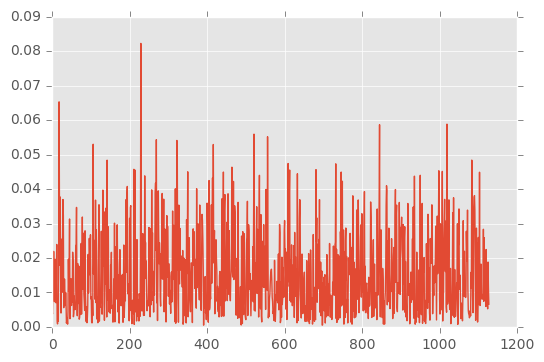

In [26]:
plt.plot(summary.variance())

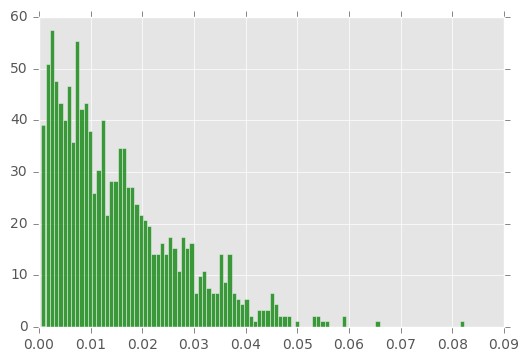

In [27]:
plt.hist(summary.variance(), bins=100, normed=1, facecolor='green', alpha=0.75)
plt.show()

#### Save M_matrix to pickle

In [72]:
with open('M_matrix.pickle', 'wb') as handle:
    pickle.dump(M_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [179]:
with open('M_matrix_movieIds.pickle', 'wb') as handle:
    pickle.dump(M_matrix_movieIds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
#Load from pickle

with open('M_matrix.pickle', 'rb') as handle:
    M_matrix = pickle.load(handle)
    
with open('M_matrix_movieIds.pickle', 'rb') as handle:
    M_matrix_movieIds = pickle.load(handle)


#### Eigenvalues

In [23]:
# covariance matrix of M
M_matrix_no_mean = M_matrix - np.array([np.mean(M_matrix, axis=1)]).T
M_cov = np.cov(M_matrix_no_mean)
M_cov

array([[ 0.00490042,  0.00327346, -0.00030115, ...,  0.00016838,
        -0.00016172, -0.00014599],
       [ 0.00327346,  0.00374098, -0.00023234, ...,  0.00011866,
        -0.00015645, -0.00014514],
       [-0.00030115, -0.00023234,  0.01184989, ...,  0.00130349,
        -0.00112118, -0.00035662],
       ..., 
       [ 0.00016838,  0.00011866,  0.00130349, ...,  0.0188282 ,
        -0.00114338, -0.00032847],
       [-0.00016172, -0.00015645, -0.00112118, ..., -0.00114338,
         0.01105378,  0.00659333],
       [-0.00014599, -0.00014514, -0.00035662, ..., -0.00032847,
         0.00659333,  0.00658031]])

In [26]:
eigvalues, eigvectors = np.linalg.eigh(M_cov)

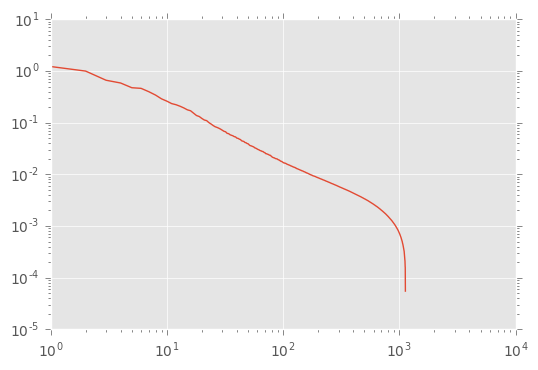

In [27]:
#TODO describe axes and title

eigvalues_plot = eigvalues.tolist()
eigvalues_plot.reverse()
plt.loglog(eigvalues_plot)
plt.show()

In [28]:
# For example, how many principal directions do you need to capture 2/3 of the variability in the data?
cumulative = (np.cumsum(eigvalues_plot) / np.sum(eigvalues))

most_significant_principal_directions = [ n for n,i in enumerate(cumulative) if i>((2./3) ) ][0]
most_significant_principal_directions

36

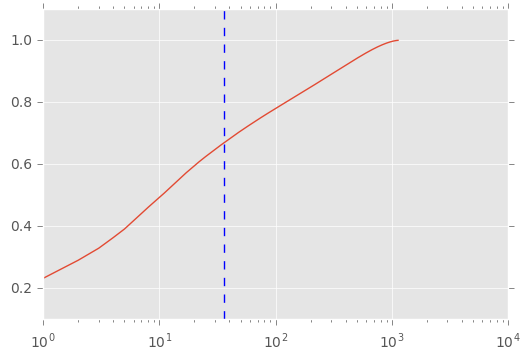

In [29]:
#TODO describe axes and title

plt.semilogx(cumulative)
plt.axvline(most_significant_principal_directions, linestyle='dashed')
plt.show()

In [30]:
#TODO • Explain the implications for dimensionality reduction.

#### Exercise 3.2 Concept space

For the five first principal directions, find the 10 tags that have the highest and lowest
coordinates in that direction.

• What concepts would you use to describe these dimensions?

Create a Python dict which maps every tag (name) to its coordinates in the 5 first principal directions and save it to disk. This will be used later for the clustering exercise.

In [31]:
#A * x = lambd * x

In [32]:
first_five_eigenvalues = eigvalues_plot[:5]
first_five_eigenvalues

[2.7533774797813515,
 1.2214710425886666,
 0.9960515193084871,
 0.6621755002074047,
 0.5857297851139422]

In [33]:
eigvectors

array([[ 0.00205699, -0.0053407 ,  0.0062789 , ...,  0.00124553,
        -0.01383799, -0.00572728],
       [-0.00078554, -0.00303118,  0.00347284, ...,  0.00206112,
        -0.01048045, -0.00478882],
       [ 0.00044356, -0.00104207,  0.00037798, ...,  0.02393293,
         0.00278201,  0.01246704],
       ..., 
       [ 0.00093566, -0.00050236,  0.00263286, ...,  0.03252862,
        -0.00551248,  0.01719115],
       [-0.00228662,  0.01518848,  0.00429738, ..., -0.0399581 ,
        -0.01417361, -0.01026643],
       [ 0.00059397, -0.01100711, -0.00067457, ..., -0.01634403,
        -0.00551606, -0.00137267]])

In [34]:
first_five_eigenvectors = eigvectors[:,-5:].T
first_five_eigenvectors = first_five_eigenvectors[::-1] # flip the order back to correct (highest to lowest)
first_five_eigenvectors

array([[-0.00572728, -0.00478882,  0.01246704, ...,  0.01719115,
        -0.01026643, -0.00137267],
       [-0.01383799, -0.01048045,  0.00278201, ..., -0.00551248,
        -0.01417361, -0.00551606],
       [ 0.00124553,  0.00206112,  0.02393293, ...,  0.03252862,
        -0.0399581 , -0.01634403],
       [-0.00645959, -0.00525968,  0.01488517, ..., -0.01063545,
         0.00476552,  0.0037956 ],
       [ 0.00537026,  0.00320727,  0.02648181, ...,  0.03512377,
        -0.01902386, -0.00852925]])

In [35]:
# verify that order of eigenvalues and eigenvectors is correct
verification = np.zeros(1128)
for i, val in enumerate(first_five_eigenvalues):
    verification += (first_five_eigenvalues[i]*first_five_eigenvectors[i]) - (np.dot(M_cov, first_five_eigenvectors[i]))

# if verification ~= 0 then correct order
np.sum(verification)

2.6206323555980592e-14

In [62]:
for i, eigenvector in enumerate(first_five_eigenvectors):
#     eigenspace = (np.dot(M_cov, first_five_eigenvectors[0])) # not sure if correct
    
    #TODO: VERIY WHICH APPROACH IS CORRECT
    eigenmatrix = np.array([np.ones(1128)]).T * (np.dot( eigenvector, M_matrix_no_mean))
    eigenspace = np.linalg.norm((M_matrix_no_mean - eigenmatrix), axis=1)
    
    #TODO: VERIFY IF THIS IS CORRECT
    eigenspace_projection = np.dot(eigenvector, M_matrix_no_mean)
    eigenspace = np.dot(M_matrix_no_mean, eigenspace_projection.T)
    
    indices = eigenspace.argsort()
    top_10 = indices[:10]
    lowest_10 = indices[-10:]
    print('Eigenvector {}\n'.format(i+1))
    print('Top vs. lowest')
    for i, val in enumerate(top_10):
        print('{}\t\t\t{}'.format(tag2name[val], tag2name[lowest_10[i]]))
    print('\n\n')

Eigenvector 1

Top vs. lowest
powerful ending			cia
snakes			drama
bad ending			blaxploitation
silent			oscar (best cinematography)
silly			dragons
hong kong			great
france			imagination
kurosawa			crime gone awry
biblical			soccer
colourful			talking animals



Eigenvector 2

Top vs. lowest
absurd			sex comedy
special			melancholic
biblical			art
character study			medieval
fashion			god
survival			lone hero
good acting			meditative
pixar animation			crime gone awry
pg			reflective
action			interracial romance



Eigenvector 3

Top vs. lowest
horrible			fbi
weed			gilliam
creativity			costume drama
spies			swedish
stupidity			romance
cult			torture
distopia			heartbreaking
vigilantism			love
cult classic			self discovery
dancing			feel good movie



Eigenvector 4

Top vs. lowest
corporate america			beautiful scenery
creepy			special
muppets			school
police corruption			science
thought-provoking			visual
survival			science fiction
vigilantism			sci fi
police			imaginary friend
gangster	

• What concepts would you use to describe these dimensions?

There is gotta be an error in our thought process because top movies do not fall into single category

In [37]:
#TODO: Create a Python dict which maps every tag (name) to its coordinates in the 5 first principal directions 
#and save it to disk. This will be used later for the clustering exercise. 

In [51]:
eigenspace = np.dot(first_five_eigenvectors, M_matrix_no_mean)
projection = np.dot(M_matrix_no_mean, eigenspace.T)
projection.shape

(1128, 5)

In [55]:
tags_mapped = {}

for key, value in tag2name.items():
    tags_mapped[value] = projection[key-1,:]

In [56]:
tags_mapped

{'disney': array([-477.98651415, -104.54968489,  328.25811066,  126.06741198,
         -45.6655703 ]),
 'sacrifice': array([ 1257.94692642,  -621.62189176,   672.73709505,   216.83509965,
          202.09260886]),
 'memory': array([ 495.82292071, -213.488369  ,  -18.08087493,  319.63944544,
          86.93572867]),
 'oscar (best editing)': array([ 492.81837607, -307.21132635,  229.47919567,  -60.22215485,
           0.98346369]),
 'vampires': array([-122.19344284,  -60.29919702, -140.5159688 ,   37.72474032,
         -34.13822488]),
 'oscar (best cinematography)': array([ 1660.10523649,  -209.88375507,   478.6100259 ,    15.72317529,
          185.17975576]),
 'dark': array([ 2041.86658817,  -453.20560412,  -961.42041515,    78.56925044,
          -82.20988289]),
 'good sequel': array([-423.4545227 , -457.04207296,   -4.31515757,   97.22323194,
         -52.52470938]),
 'disability': array([ 421.8160066 ,    3.85482631,  235.81987049,   16.80105104,
         -70.93824365]),
 'mockument

### Exercise 3.3 Movie visualization

In [38]:
#Load from pickle
with open('selected-movies.pickle', 'rb') as handle:
    selected_movies = pickle.load(handle, encoding='utf-8') # encoding='latin1'

In [39]:
selected_movies

((780, 'Independence Day (a.k.a. ID4) (1996)', 0.6),
 (5349, 'Spider-Man (2002)', 0.89),
 (2571, 'Matrix, The (1999)', 0.87),
 (318, 'Shawshank Redemption, The (1994)', 0.91),
 (2329, 'American History X (1998)', 0.83),
 (5147, 'Wild Strawberries (Smultronstället) (1957)', 0.95),
 (55444, 'Control (2007)', 0.87),
 (32296, 'Miss Congeniality 2: Armed and Fabulous (2005)', 0.15),
 (43930, 'Just My Luck (2006)', 0.13),
 (4658, 'Santa Sangre (1989)', 0.85),
 (6774, 'Videodrome (1983)', 0.78),
 (3967, 'Billy Elliot (2000)', 0.85),
 (114028, 'Pride (2014)', 0.92),
 (480, 'Jurassic Park (1993)', 0.93),
 (260, 'Star Wars: Episode IV - A New Hope (1977)', 0.93),
 (4700, 'Princess Diaries, The (2001)', 0.47),
 (527, "Schindler's List (1993)", 0.96),
 (2959, 'Fight Club (1999)', 0.79),
 (6132, 'New York Ripper, The (Squartatore di New York, Lo) (1982)', 0.17),
 (2858, 'American Beauty (1999)', 0.88),
 (6016, 'City of God (Cidade de Deus) (2002)', 0.9),
 (94018, 'Battleship (2012)', 0.34),
 (5687,

In [40]:
len(selected_movies)

37

In [41]:
indeces = []
names = []
ratings = []
for row in selected_movies:
    movieId = row[0]
    movieName = row[1]
    movieRating = row[2]
    
    index_in_M_matrix = M_matrix_movieIds.index(movieId)
    indeces.append(index_in_M_matrix)
    names.append(movieName)
    ratings.append(movieRating)

In [42]:
selected_M_matrix = M_matrix[:,indeces]
selected_M_matrix.shape

(1128, 37)

In [43]:
pca_2d = first_five_eigenvectors.T[:,:2]
pca_2d.shape

(1128, 2)

In [44]:
projected = pca_2d.T.dot(selected_M_matrix)
projected.shape

(2, 37)

In [45]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
import matplotlib as mpl
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import HoverTool
output_notebook()


output_file("selected_ratings.html")

source = ColumnDataSource(
        data=dict(
            x=projected[0,:],
            y=projected[1,:],
            desc=names,
            rating=ratings
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Name", "@desc"),
            ("Rating", "@rating"),
        ]
    )

p = figure(plot_width=400, plot_height=400, tools=[hover],
           title="Visualization of selected movies")
p.xaxis.axis_label = 'First Principal Direction'
p.yaxis.axis_label = 'Second Principal Direction'

colors = [
    "#%02x%02x%02x" % (255-int(r), int(g), 0) for r, g, b, _ in 255*mpl.cm.viridis(mpl.colors.Normalize()(ratings))
]
p.circle('x', 'y', fill_alpha=0.2, color=colors, size=10, source=source)

show(p)

Loading BokehJS ...

• Based on your knowledge of these movies and information that you can get from the
web, explain the coordinates of a few of the movies.

It seems like first principal direction corresponds to 'seriousness' of the movie since movies with high value for 1st principal direction are heavy dramas, whilst movies with low value are silly comedies. 

Second principal direction on the other hand seems to describe 'realism' of the movie since movies with low value for this direction are sci-fi movies while movies with higher values seem to be more plausible when it comes to scenario happening in real world.

• How do the PCA directions correlate with the Rotten Tomatoes score?

Judging by the color distribution in our visualisation it seems like there exists some slight correlation of Rotten Tomatoes score with first principal direction as most movies with low value for first direction have also low rating.

In [182]:
#TODO? prove correlation?